<a href="https://colab.research.google.com/github/sathwikreddykatla/tutorial/blob/master/ml2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 0: Loss: 0.2656012177467346
Epoch 30: Loss: 0.22896528244018555
Epoch 60: Loss: 0.20527544617652893
Epoch 90: Loss: 0.17485754191875458
Epoch 120: Loss: 0.14020270109176636
Epoch 150: Loss: 0.10596528649330139
Epoch 180: Loss: 0.07557028532028198
Epoch 210: Loss: 0.051293037831783295
Epoch 240: Loss: 0.03272981941699982
Epoch 270: Loss: 0.019146841019392014
Epoch 300: Loss: 0.009913284331560135
Epoch 330: Loss: 0.004496759735047817
Epoch 360: Loss: 0.0017612171359360218
Epoch 390: Loss: 0.0005840315716341138
Epoch 420: Loss: 0.00016457638412248343
Epoch 450: Loss: 3.996394661953673e-05
Epoch 480: Loss: 8.952377356763463e-06


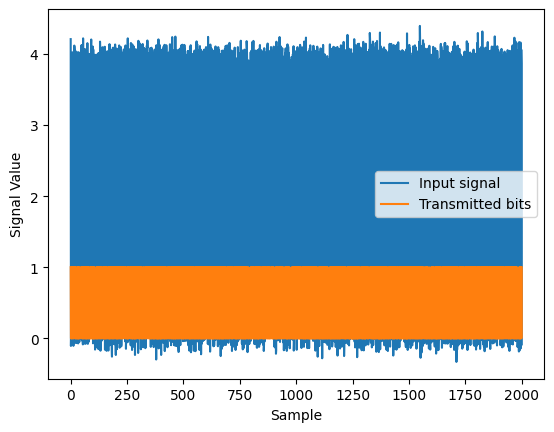

In [1]:
import numpy as np
import tensorflow as tf
from scipy.stats import levy_stable
import matplotlib.pyplot as plt

# Constants and hyperparameters
learning_rate = 0.001
batch_size = 200
epochs = 500
c1 = np.sqrt(16)  # power allocation factor
c2 = np.sqrt(4)   # power allocation factor

# Quantization function
def quantized(y, q_levels, q_range):
    delta = 2 * q_range / q_levels
    value_max = q_range - delta / 2
    y_quantized = delta * np.floor((y + q_range) / delta) - value_max
    y_quantized[np.where(y_quantized > value_max)] = value_max
    y_quantized[np.where(y_quantized < -value_max)] = -value_max
    return y_quantized

# Build model with Keras Sequential API for simplicity
def build_decoder_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(16, activation="relu"),
        tf.keras.layers.Dense(8, activation="relu"),
        tf.keras.layers.Dense(1, activation="sigmoid")
    ])
    return model

decoder1 = build_decoder_model()
decoder2 = build_decoder_model()
decoder3 = build_decoder_model()

# Example function to generate data
def generate_data(block_size, noise_std, h):
    coded_bits3 = np.random.binomial(n=1, p=0.5, size=(block_size, 1))  # example binary data
    x = coded_bits3 * c1  # transmitted signal with coding
    noise = noise_std * np.random.normal(0, 1, x.shape)
    y = h * x + noise
    y_reshaped = np.reshape(y, (len(y), 1))
    return y_reshaped, coded_bits3

# Training function using GradientTape for each model
# Training function using GradientTape for each model
def train_model(model, y_data, s3_data):
    for epoch in range(epochs):
        with tf.GradientTape() as tape:
            pred = model(y_data, training=True)
            loss = tf.reduce_mean(tf.keras.losses.MeanSquaredError()(s3_data, pred))
        grads = tape.gradient(loss, model.trainable_variables)
        tf.optimizers.Adam(learning_rate).apply_gradients(zip(grads, model.trainable_variables))
        if epoch % 30 == 0:
            print(f"Epoch {epoch}: Loss: {loss.numpy()}")

# Generate sample data and train model
h = 1  # Assuming a static channel
block_size = 2000
noise_std = 0.1
y_data, s3_data = generate_data(block_size, noise_std, h)
train_model(decoder1, y_data, s3_data)

# Plotting (sample)
plt.plot(y_data, label='Input signal')
plt.plot(s3_data, label='Transmitted bits')
plt.xlabel("Sample")
plt.ylabel("Signal Value")
plt.legend()
plt.show()


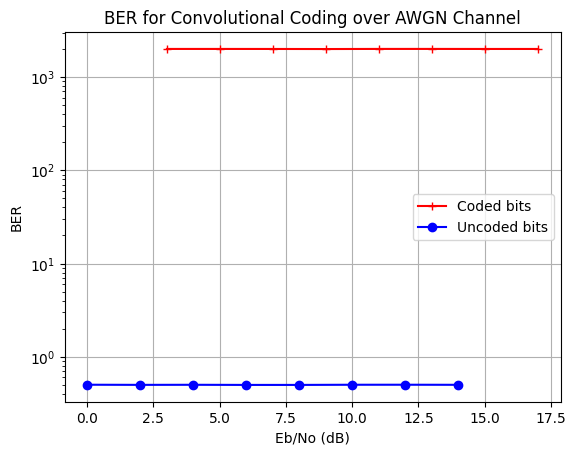

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from commpy.channelcoding.convcode import Trellis
from commpy.channelcoding import viterbi_decode, conv_encode

# Define convolutional coding parameters
generator_matrix = np.array([[5, 7]])  # In octal: '101', '111'
trellis = Trellis(np.array([2]), generator_matrix)  # Constraint length = 3

# Channel and simulation parameters
EbNodB = list(np.linspace(0, 14, 8))
num_blocks = 100
block_size = 2000
code_rate = 1 / 2

# Hyperparameters
learning_rate = 0.001
batch_size = 200
epochs = 300
act_func = tf.nn.relu

# Model definition using Keras
class DecoderModel(tf.keras.Model):
    def __init__(self, layers):
        super(DecoderModel, self).__init__()
        self.dense_layers = [tf.keras.layers.Dense(units, activation=act_func) for units in layers]

    def call(self, x):
        for layer in self.dense_layers:
            x = layer(x)
        return x

# Define models
decoder1 = DecoderModel([16, 8, 1])
decoder2 = DecoderModel([24, 12, 1])
decoder3 = DecoderModel([32, 16, 1])

# Data generation and decoding functions
def generate_data(block_size, noise_std, h):
    uncoded_bits = np.random.randint(0, 2, block_size)
    coded_bits = conv_encode(uncoded_bits, trellis)  # Use the Trellis object for encoding
    x = 2 * coded_bits - 1
    noise = noise_std * np.random.normal(0, 1, x.shape)
    y = h * x + noise
    return np.reshape(y, (-1, 1)), np.reshape(coded_bits, (-1, 1)), uncoded_bits

def decode_bits(y_, decoder1, decoder2, decoder3):
    p1 = decoder1(y_)
    z2 = tf.concat([y_, p1], axis=-1)
    p2 = decoder2(z2)
    z3 = tf.concat([z2, p2], axis=-1)
    p3 = decoder3(z3)
    return p3

# Simulation
ber_coded, ber_uncoded = [], []

for EbNo_dB in EbNodB:
    EbNo = 10 ** (EbNo_dB / 10.0)
    noise_std = np.sqrt(1 / (2 * code_rate * EbNo))

    num_errors_coded, num_errors_uncoded = 0, 0
    coded_bit_count, uncoded_bit_count = 0, 0

    for block in range(num_blocks):
        y_, coded_bits, uncoded_bits = generate_data(block_size, noise_std, h=1)
        y_tensor = tf.convert_to_tensor(y_, dtype=tf.float32)

        # Decode
        p3 = decode_bits(y_tensor, decoder1, decoder2, decoder3)
        s_re = tf.sign(p3.numpy().flatten() - 0.5)

        # Use tf.round and convert to int
        decoded_bits = tf.round((s_re + 1) / 2).numpy().astype(int)
        uncoded_bits_re = viterbi_decode(decoded_bits, trellis, tb_depth=5)

        uncoded_bit_count += len(uncoded_bits)
        coded_bit_count += len(coded_bits)
        num_errors_uncoded += np.sum(uncoded_bits != uncoded_bits_re[:len(uncoded_bits)])
        num_errors_coded += np.sum(coded_bits != decoded_bits[:len(coded_bits)])

    ber_coded.append(num_errors_coded / coded_bit_count)
    ber_uncoded.append(num_errors_uncoded / uncoded_bit_count)

# Plot results
EbNodB_coded = list(np.asarray(EbNodB) - 10 * np.log10(code_rate))
plt.plot(EbNodB_coded, ber_coded, '-r+', label='Coded bits')
plt.plot(EbNodB, ber_uncoded, '-bo', label='Uncoded bits')
plt.yscale('log')
plt.xlabel('Eb/No (dB)')
plt.ylabel('BER')
plt.title('BER for Convolutional Coding over AWGN Channel')
plt.legend()
plt.grid()
plt.show()
